In [1]:
import numpy as np
from glob import glob
from datetime import datetime
import pypff
import matplotlib.pyplot as plt
import pandas as pd
import pytz
%matplotlib widget

In [2]:
def read_qerr_df(fpath):
    with open(fpath, 'r') as f:
        df = pd.read_csv(f, index_col=0)
    return df

def convert_to_unixt(dt_t):
    # convert string to localtime
    localtime = pd.to_datetime(dt_t, unit='ns')
    # convert localtime to utc time
    utctime = localtime.dt.tz_localize('US/Pacific').dt.tz_convert('utc')
    unixt = []
    for t in utctime:
        unixt.append(datetime.timestamp(t))
    return np.array(unixt)

def convert_wr_time(md):
    pkt_tai = md['pkt_tai'].flatten()
    pkt_nsec = md['pkt_nsec'].flatten()
    tv_sec = md['tv_sec'].flatten()
    tv_usec = md['tv_usec'].flatten()
    for i in range(len(pkt_tai)):
        tv_sec_10bit = (tv_sec[i]+37)%1024
        if pkt_tai[i] == tv_sec_10bit:
            # situation 1: the timestamp is in the middle of a sec
            pkt_tai[i] = tv_sec[i]
        elif pkt_tai[i] == tv_sec_10bit + 1 or pkt_tai[i] == tv_sec_10bit - 1023:
            # situation 2: tai time is 1 sec slower than localtime
            # this should happen when the nsec of tai time is very close to 0.0001
            # for example, the tai time is xxxx2.0001, the localtime is xxxx1.9999
            # so the real tai should be 
            pkt_tai[i] = tv_sec[i] + 1
            # let's check the nsec, and make sure it's correct
            if pkt_nsec[i]*1.0/10**9 > 0.5 or tv_usec[i]*1.0/10**6 < 0.5:
                print('TimeStamps convert incorrectly in situation 2')
        elif pkt_tai[i] == tv_sec_10bit - 1 or pkt_tai[i] == tv_sec_10bit + 1023:
            # situation 3: the tai time is xxxxx1.99999, the localtime is xxxx 2.00001
            pkt_tai[i] = tv_sec[i] - 1
            # let's check the nsec, and make sure it's correct
            if pkt_nsec[i]*1.0/10**9 < 0.5 or tv_usec[i]*1.0/10**6 > 0.5:
                print('TimeStamps convert incorrectly in situation 3')
        else:
            print('error')
    md['pkt_tai'] = pkt_tai.astype(np.float64)
    md['pkt_nsec'] = pkt_nsec.astype(np.float64)
    md['tv_sec'] = tv_sec.astype(np.float64)
    md['tv_usec'] = tv_usec.astype(np.float64)
    return md

In [3]:
data_dir = 'field_timing_data'
#run_dir = 'obs_UCB_lab.start_2024-08-23T02:40:52Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-26T03:58:01Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-29T04:29:01Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-29T16:31:13Z.runtype_eng-test.pffd'
run_dir = 'obs_UCB_lab.start_2024-08-30T01:12:04Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-08-31T15:47:25Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-09-01T04:18:11Z.runtype_eng-test.pffd'
#run_dir = 'obs_UCB_lab.start_2024-09-03T15:58:34Z.runtype_eng-test.pffd'

qerr0_file = glob('%s/%s/qErr/*ttyS10/*MERGED*'%(data_dir,run_dir))[0]
qerr1_file = glob('%s/%s/qErr/*ttyUSB0/*MERGED*'%(data_dir,run_dir))[0]

timing0_file = glob('%s/%s/*dp_ph256*_*251*'%(data_dir, run_dir))[0]
timing1_file = glob('%s/%s/*dp_ph256*_*253*'%(data_dir, run_dir))[0]

print(qerr0_file.split('/')[-1])
print(qerr1_file.split('/')[-1])
print(timing0_file.split('/')[-1])
print(timing1_file.split('/')[-1])

data-type_MERGED.start_2024-08-29T18:11:27.230202
data-type_MERGED.start_2024-08-29T18:11:15.103059
start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_251.seqno_0.pff
start_2024-08-30T01:12:12Z.dp_ph256.bpp_2.module_253.seqno_0.pff


In [4]:
# read qerr data
qerr0_df = read_qerr_df(qerr0_file)
qerr1_df = read_qerr_df(qerr1_file)

qerr0 = np.array(qerr0_df['qErr (ps)'])
qerr0_ts = convert_to_unixt(qerr0_df['pkt_unix_timestamp_TIM-TP'])
qerr1 = np.array(qerr1_df['qErr (ps)'])
qerr1_ts = convert_to_unixt(qerr1_df['pkt_unix_timestamp_TIM-TP'])

# read timing data
dpff0 = pypff.io.datapff(timing0_file)
d0, md00 = dpff0.readpff(ver='qfb', metadata=True)
dpff1 = pypff.io.datapff(timing1_file)
d1, md01 = dpff1.readpff(ver='qfb', metadata=True)

In [5]:
# correct the wr time, as the tai int part is only 10 bits
md0 = convert_wr_time(md00)
md1 = convert_wr_time(md01)

In [6]:
delta0 = int(md0['pkt_tai'][0] - qerr0_ts[0])
wr_t0 =md0['pkt_nsec'] - md0['pkt_nsec'][0]
qerr_0 = qerr0[delta0-3:]/1000.0

delta1 = int(md1['pkt_tai'][0] - qerr1_ts[0])
wr_t1 =md1['pkt_nsec'] - md1['pkt_nsec'][0]
qerr_1 = qerr1[delta1+1:]/1000.0

In [7]:
np.mean(qerr_0)

-0.11475446318847057

In [8]:
np.mean(qerr_1)

-0.10560892007239737

In [16]:
wr_nsec0

array([ 0.,  7.,  7., ...,  0.,  2., -2.])

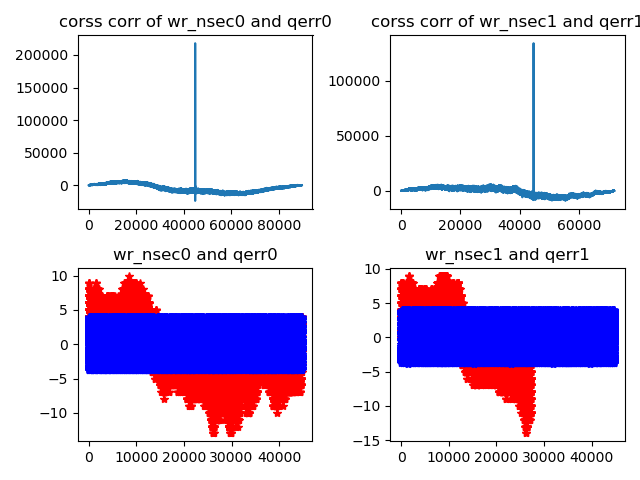

In [14]:
# use cross correlation to align the data
# for quabo0
qerr_0 = -1.0*qerr0/1000
wr_nsec0 = md0['pkt_nsec'] - md0['pkt_nsec'][0]
corr0=np.correlate(wr_nsec0, qerr_0, 'full')
index0 = np.where(corr0 == corr0.max())[0][0] - len(qerr_0) + 1
qerr_0 = qerr_0[-index0:]
# for quabo1
qerr_1 = -1.0*qerr1/1000
wr_nsec1 = md1['pkt_nsec'] - md1['pkt_nsec'][0]
corr1=np.correlate(wr_nsec1, qerr_1, 'full')
index1 = np.where(corr1 == corr1.max())[0][0] - len(qerr_1) + 1
qerr_1 = qerr_1[-index1:]

plt.close('all')
fig = plt.figure()
subfig0 = fig.add_subplot(221)
subfig0.plot(corr0)
subfig0.set_title('corss corr of wr_nsec0 and qerr0')

subfig1 = fig.add_subplot(222)
subfig1.plot(corr1)
subfig1.set_title('corss corr of wr_nsec1 and qerr1')

subfig2 = fig.add_subplot(223)
subfig2.plot(wr_nsec0, marker='*', c='red')
subfig2.plot(qerr_0, marker='*',c='blue')
subfig2.set_title('wr_nsec0 and qerr0')

subfig3 = fig.add_subplot(224)
subfig3.plot(wr_nsec1, marker='*', c='red')
subfig3.plot(qerr_1, marker='*',c='blue')
subfig3.set_title('wr_nsec1 and qerr1')

plt.tight_layout()

In [10]:
l = len(wr_nsec1)
fix_wr_nsec0 = wr_nsec0[:l] - qerr_0[:l] + md0['pkt_nsec'][0]
fix_wr_nsec1 = wr_nsec1[:l] - qerr_1[:l] + md1['pkt_nsec'][0]

delta_t = fix_wr_nsec0 -fix_wr_nsec1
delta_t_qerr = wr_nsec0[:l] - wr_nsec1[:l] + md0['pkt_nsec'][0] - md1['pkt_nsec'][0]

Mean: 0.25531412721104874
Std: 0.6980786346260089


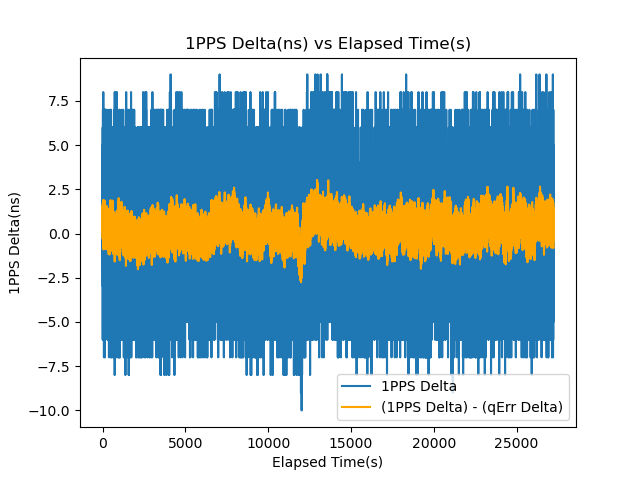

In [17]:
plt.close('all')
fig = plt.figure()
subfig = fig.add_subplot(111)
subfig.plot(delta_t_qerr)
subfig.plot(delta_t, c='orange')
subfig.legend(['1PPS Delta', '(1PPS Delta) - (qErr Delta)'])
subfig.set_title('1PPS Delta(ns) vs Elapsed Time(s)')
subfig.set_xlabel('Elapsed Time(s)')
subfig.set_ylabel('1PPS Delta(ns)')
print('Mean:', np.mean(delta_t))
print('Std:', np.std(delta_t))


In [12]:
print('qerr0_ts: ', qerr0_ts[-index0])
print('qerr1_ts: ', qerr1_ts[-index1])
print('wr0_ts  : ', md0['pkt_tai'][0]+md0['pkt_nsec'][0]/10**9)
print('wr1_ts  : ', md1['pkt_tai'][0]+md1['pkt_nsec'][0]/10**9)

qerr0_ts:  1724980338.087049
qerr1_ts:  1724980338.083002
wr0_ts  :  1724980338.6020172
wr1_ts  :  1724980338.6020172


Text(0.5, 0, 'Time (PDT)')

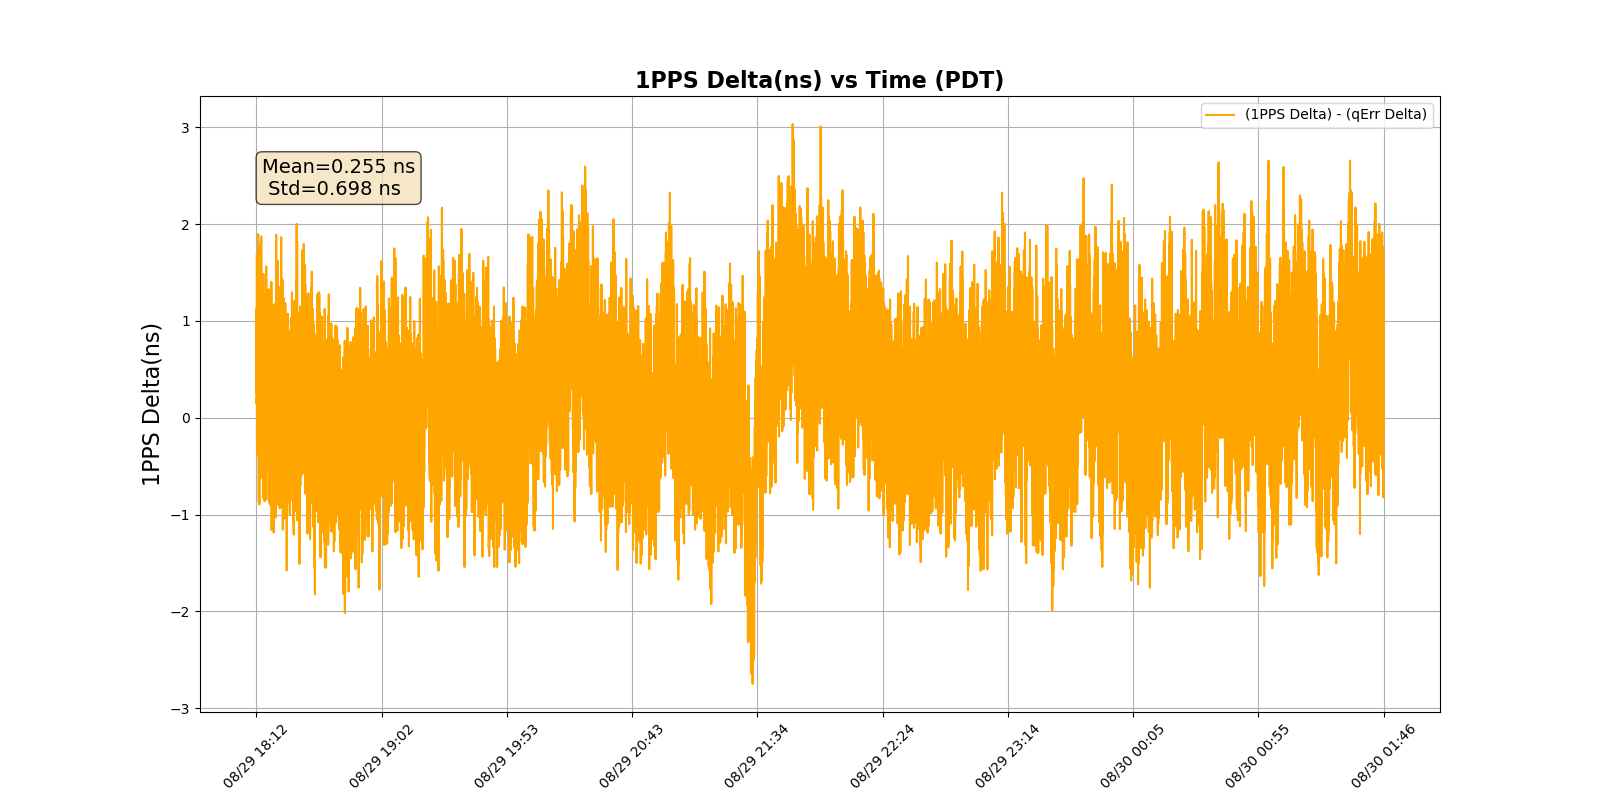

In [13]:
t_start =  md1['pkt_tai'][0]+md1['pkt_nsec'][0]/10**9
t_end =  md1['pkt_tai'][-1]+md1['pkt_nsec'][-1]/10**9
totalTics = 10
#minTic = allTimes[0].timestamp()
#maxTic = allTimes[-1].timestamp()
minTic = t_start
maxTic = t_end
stepSize = (maxTic - minTic) / (totalTics - 1)

# Get locations of all the tics
allTics = np.arange(minTic, maxTic + 0.99 * stepSize, stepSize)
#print(allTics)
timezone = pytz.timezone('America/Los_Angeles')
# Overwrit the labels with custom dates
labelTimes = [datetime.fromtimestamp(x, tz=timezone).strftime("%m/%d %H:%M") for x in allTics]
labelSecs = [x for x in range(len( md1['pkt_tai']))]

plt.close('all')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

textstr = '\n'.join((
    r'Mean=%.3f ns' %(np.mean(delta_t)),
    r' Std=%.3f ns' % (np.std(delta_t))))
title_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'bold'}
label_font = {'fontname':'sans-serif', 'size':'16', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} 

fig = plt.figure(figsize=[16,8])
#fig = plt.figure()
subfig = fig.add_subplot(111)
#subfig.plot(delta_t_qerr)
subfig.plot(delta_t, c='orange')
subfig.legend(['(1PPS Delta) - (qErr Delta)'])
subfig.set_title('1PPS Delta(ns) vs Time (PDT)', **title_font)
#subfig.set_xlabel('Elapsed Time(s)')
subfig.set_ylabel('1PPS Delta(ns)', **label_font)
subfig.grid()
subfig.set_xticks(np.arange(labelSecs[0],labelSecs[-1] + 0.99*(labelSecs[1] - labelSecs[0]), (labelSecs[-1] - labelSecs[0])/(totalTics-1)))
subfig.set_xticklabels(labelTimes, rotation = 45)
subfig.text(0.05, 0.90, textstr, transform=subfig.transAxes, fontsize=14, verticalalignment='top', bbox=props)
subfig.set_xlabel('Time (PDT)', labelpad = 30, **label_font)


In [14]:
labelTimes

['08/29 18:12',
 '08/29 19:02',
 '08/29 19:53',
 '08/29 20:43',
 '08/29 21:34',
 '08/29 22:24',
 '08/29 23:14',
 '08/30 00:05',
 '08/30 00:55',
 '08/30 01:46']